In [1]:
# third party
import matplotlib.pyplot as plt

# relative import
#from mnist_dataset import mnist
#from mnist_dataset import mnist_raw
import numpy as np

# syft absolute
import syft as sy

print(f"{sy.__version__ = }")

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                    🚨🚨🚨 Hagrid has been deprecated. 🚨🚨🚨                                    │
│    Please refer to ]8;id=475815;https://github.com/OpenMined/PySyft/tree/dev/notebooks/tutorials/deployments\https://github.com/OpenMined/PySyft/tree/dev/notebooks/tutorials/deployments]8;;\ for the new     │
│                                            deployment instructions.                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

sy.__version__ = '0.8.6'


## 1. Launch the domain, upload the data

In [2]:
node = sy.orchestra.launch(name="esol-domain", dev_mode=True, reset=True)
root_client = node.login(email="info@openmined.org", password="changethis")

Staging Protocol Changes...
Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=44f5729b7d1a4a4d8e458ca9983fc9a1 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <esol-domain: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

In [5]:
root_client.me.set_password("zx")

Please confirm your password:  ········


SyftSuccess: Successfully updated password for user 'Jane Doe' with email 'info@openmined.org'.

### Load the MNIST dataset

Let's load the raw ESOL samples and show with the `mnist_raw` function from [`mnist_datasets.py`](./datasets.py)

In [6]:
from torch_geometric.datasets import MoleculeNet
 
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MoleculeNet.html#torch_geometric.datasets.MoleculeNet
DATA = MoleculeNet(root=".", name="ESOL")
DATA

ESOL(1128)

In [7]:
print("Dataset type: ", type(DATA))
print("Number of features per graph node: ", DATA.num_features)
print("Number of distinct target values (solubilities): ", DATA.num_classes)
print("Number of graphs: ", len(DATA))
print("Example graph: ", DATA[0])
print("Number of nodes in example graph: ", DATA[0].num_nodes)
print("Number of edges in example graph: ", DATA[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per graph node:  9
Number of distinct target values (solubilities):  734
Number of graphs:  1128
Example graph:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Number of nodes in example graph:  32
Number of edges in example graph:  68


In [8]:
# edge attributes of example graph
#DATA[0].edge_attr # shape [num_edges, num_edge_features]

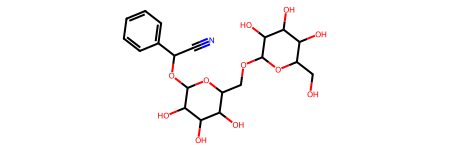

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles(DATA[0]["smiles"])

In [10]:
# ** In the following cell x, edge_index, edge_attr, smiles, y are the private data. We also create similar mock data with the same shape

In [11]:
x, edge_index, edge_attr, smiles, y = [] , [], [] , [], []
x_mock, edge_index_mock, edge_attr_mock, smiles_mock, y_mock = [] , [], [] , [], []

for i, element in enumerate(DATA):
        x_i, edge_index_i, edge_attr_i, smiles_i, y_i = DATA[i]

        x.append(np.array(x_i[1]))
        edge_index.append(np.array(edge_index_i[1]))
        edge_attr.append(np.array(edge_attr_i[1]))
        y.append(np.array(y_i[1]))



In [12]:
import numpy as np

def pad_arrays_and_create_masks(array_list):
    """
    Pads a list of numpy arrays to the same shape and creates a mask array indicating the original data.

    Parameters:
    array_list (list of np.ndarray): List of numpy arrays with different shapes.

    Returns:
    tuple: (padded_arrays, masks)
        - padded_arrays (np.ndarray): The padded arrays.
        - masks (np.ndarray): The mask arrays indicating original data (1) and padding (0).
    """
    # Determine the shape of the largest array
    max_shape = tuple(max(sizes) for sizes in zip(*[arr.shape for arr in array_list]))

    def pad_and_create_mask(arr, target_shape):
        pad_widths = [(0, m - s) for s, m in zip(arr.shape, target_shape)]
        padded_arr = np.pad(arr, pad_widths, mode='constant')
        mask = np.pad(np.ones_like(arr, dtype=int), pad_widths, mode='constant', constant_values=0)
        return padded_arr, mask

    # Pad each array to the max shape and create masks
    padded_arrays = []
    masks = []
    for arr in array_list:
        padded_arr, mask = pad_and_create_mask(arr, max_shape)
        padded_arrays.append(padded_arr)
        masks.append(mask)

    # Stack padded arrays and masks into one array each
    result_array = np.array(padded_arrays)
    mask_array = np.array(masks)

    return result_array, mask_array


In [13]:

x_padded, x_masks = pad_arrays_and_create_masks(x)
edge_index_padded, edge_index_masks = pad_arrays_and_create_masks(edge_index)
edge_attr_padded, edge_attr_masks = pad_arrays_and_create_masks(edge_attr)
y = np.array(y)

x_mock = np.random.rand(*x_padded.shape)
edge_index_mock = np.random.rand(*edge_index_padded.shape)
edge_attr_mock = np.random.rand(*edge_attr_padded.shape)
y_mock = np.random.rand(*y.shape)


In [14]:

dataset = sy.Dataset(
    name="ESOL data",
    description="""Contains drug features.""",
)

dataset.add_contributor(
    role=sy.roles.UPLOADER,
    name="Alice",
    email="alice@openmined.com",
    note="Alice is the data engineer at the OpenMined",
)

asset_esol_train_labels = sy.Asset(
    name="ESOL training labels",
    description="""The training labels of ESOL dataset""",
    data=y,
    mock=y_mock,
)


In [15]:

asset_esol_train_input_x = sy.Asset(name="ESOL training samples x_padded",
                                  description="""The training samples x_padded of the ESOL dataset""",
                                  data=x_padded,
                                  mock=x_mock,
                                  )

asset_esol_train_input_x_masks = sy.Asset(name="ESOL training samples x_masks",
                                  description="""The training samples x_masks of the ESOL dataset""",
                                  data=x_masks,
                                  mock=x_mock,
                                  )

asset_esol_train_input_edge_index = sy.Asset(name="ESOL training samples edge_index",
                                  description="""The training samples edge_index of the ESOL dataset""",
                                  data=edge_index_padded,
                                  mock=edge_index_mock,
                                  )

asset_esol_train_input_edge_index_masks = sy.Asset(name="ESOL training samples edge_index_masks",
                                  description="""The training samples edge_index_masks of the ESOL dataset""",
                                  data=edge_index_masks,
                                  mock=edge_index_mock,
                                  )




In [16]:
dataset.add_asset(asset_esol_train_labels)
dataset.add_asset(asset_esol_train_input_x)
dataset.add_asset(asset_esol_train_input_x_masks)
dataset.add_asset(asset_esol_train_input_edge_index)
dataset.add_asset(asset_esol_train_input_edge_index_masks)



SyftSuccess: Asset 'ESOL training samples edge_index_masks' added to 'ESOL data' Dataset.

In [17]:
root_client.upload_dataset(dataset)

  0%|                                                                             | 0/5 [00:00<?, ?it/s]

Uploading: ESOL training labels


 20%|█████████████▊                                                       | 1/5 [00:00<00:01,  3.71it/s]

Uploading: ESOL training samples x_padded


 40%|███████████████████████████▌                                         | 2/5 [00:02<00:04,  1.57s/it]

Uploading: ESOL training samples x_masks


 60%|█████████████████████████████████████████▍                           | 3/5 [00:03<00:02,  1.34s/it]

Uploading: ESOL training samples edge_index


 80%|███████████████████████████████████████████████████████▏             | 4/5 [00:04<00:01,  1.04s/it]

Uploading: ESOL training samples edge_index_masks


100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


SyftSuccess: Dataset uploaded to 'esol-domain'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

### The DO inspects the uploaded data

In [18]:
datasets = root_client.api.services.dataset.get_all()
assert len(datasets) == 1
datasets

DictTuple(syft.service.dataset.dataset.Dataset,)

#### The first asset of the dataset contains the training and mock images

In [19]:
datasets[0].assets[0]

syft.service.dataset.dataset.Asset

#### The second asset contains the training and mock labels

In [20]:
datasets[0].assets[1]

syft.service.dataset.dataset.Asset

### The DO creates an account for the Data Scientist (DS)

In [21]:
register_result = root_client.register(
    name="Sheldon Cooper",
    email="sheldon@caltech.edu",
    password="changethis",
    password_verify="changethis",
    institution="Caltech",
    website="https://www.caltech.edu/",
)

In [22]:
assert isinstance(register_result, sy.SyftSuccess)

### 📓 Now switch to the [first DS's notebook](./01-data-scientist-submit-code.ipynb)